# 1. Introduction to inference

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## A note on Numpy and Matplotlib and helper functions

We will be using __[Numpy](http://www.numpy.org/)__ for this section and the entirety of the course. Numpy is a scientific computing package for Python which enables us to do vector and (multidimensional) matrix arithmetic very neatly, without any for loops and also much faster than if we used for loops because it is optimised under the hood $-$ if you're not already familiar, you will shortly be fluent with Numpy and appreciate the effort it saves. We will also use __[Matplotlib](http://www.matplotlib.org/)__ for plotting, which works very well with Numpy.

We'll try to make the use of Numpy/Matplotlib clear and explain what various methods do as we go, but looking up and finding their documentation by yourself is an important and very useful skill. We now import Numpy and Matplotlib and also some helper functions (which we will use later to make the code less cluttered).

For convenience and to make the code more readable we will also be using some custom helper functions. You shouldn't worry about their details and their names should be self-explanatory.

In [1]:
%config InlineBackend.figure_format = 'svg' # change output plot format to 'svg' - you don't need to worry about this
# In subsequent demos the next import statements will be hidden either
# within the helper_functions import or by hiding the code cell
from helper_functions import * # import some helper functions used for convenience - you don't need to worry about this
import helper_functions as h

set_notebook_preferences() # set things like fonts etc - comes from helper_functions

## Example: Radioactive decay

In this example we will introduce some inference concepts through a motivating example of radioactive decays. Suppose unstable particles are emitted from a source and decay after travelling a distance $x$. For the sake of a realistic example, suppose also that our apparatus can measure decays within the range $(x_{min}, x_{max})$ of the particle source. Physics tells us that $x$ follows an exponential distribution with a decay constant $\lambda$:

$$\begin{align}
p(x|\lambda) = \frac{1}{Z(\lambda)} \text{exp}\bigg(-\frac{x}{\lambda}\bigg)
\end{align}$$

where $Z(\lambda)$ is a normalisation coefficient of \\( p(x|\lambda) \\). After taking a number of measurements within the window \\((x_{min}, x_{max}) = (5, 50)\\) we end up with the dataset shown in the following picture

<div class="row">
  <div class="column">
    <img src="radio_numberline.svg" alt="Snow" style="width:60%; float: center; padding: 0px; padding : 20px">
  </div>
</div>

**How can we infer the value of $\boldsymbol{\lambda}$ from these measurements**? Let's start by loading the dataset and plotting it in a histogram:

In [1]:
import numpy as np # import Numpy and refer to it as np from now on
import matplotlib.pyplot as plt # similarly for matplotlib

x = np.load('radioactive.npy') # load an array of data stored in the 'radioactive.npy' file

no_bins = 7 # how many bins to use for the histogram
plt.hist(x, no_bins, range = (5, 50), color = 'blue', zorder = 1, alpha = 0.2,
         edgecolor='black', linewidth=1.2) # plot the histogram
plot = plt.scatter(x, np.zeros_like(x), marker = 'x', color = 'red', s = 100,
                   zorder = 2, clip_on=False) # plot the decays as red crosses
beautify_plot({"title":"Radioactive decays", "x":"$x$", "y":"No. occurances"}) # from helper_functions for convenience
plt.xlim([0, 55]), plt.ylim([0, 10]) # set x, y axis limits
plt.show()

NameError: name 'beautify_plot' is not defined

A first approach could be to try and infer $\lambda$ from the heights, $H$, of the bars of this histogram. The height $H_{ab}$ of the bin with limits $[a, b]$ is equal to the number of decays in that bin, which we can calculate

\begin{align}
H_{ab} &= N \int^{b}_{a}p(x|\lambda) dx\\
~\\
&\approx N p(x|\lambda) (b - a),~~\text{ in the limit of thin bins } (b - a) \to 0\\
~\\
&= \frac{N}{Z(\lambda)} \text{exp}\bigg(-\frac{x}{\lambda}\bigg) (b - a)\\
~\\
\text{ln}(H_{ab}) &= -\frac{x}{\lambda} + \text{const.}\\
\end{align}

where $N$ is the total number of datapoints and $p(x|\lambda)$ denotes the probability density of $x$ for a given $\lambda$. Because the relation between $\text{ln}(H)$ and $x$ is linear, we can infer $\lambda$ from the slope $(-1/\lambda)$ of the best-fit line of these two quantities, using standard linear least-squares regression. The Scipy package offers the function \\(\texttt{stats.linregress}\\) which does the linear regression for us.

Slope: -0.028 Decay constant: 36.219


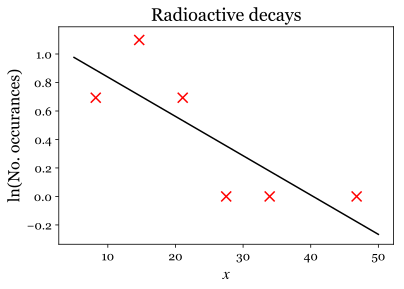

In [3]:
counts, bin_edges = np.histogram(x, no_bins, range = (5, 50)) # Count number of decays in 7 bins in the range (5, 50)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:])/2 # midpoints along x-axis of the bins

selection = np.where(counts > 0)[0] # indices of the bins which have at least one decay
counts = counts[selection] # only keep bins with non-zero number of decays (otherwise the log will be -inf later)...
bin_midpoints = bin_midpoints[selection] # ... and the corresponding bin midpoints

from scipy import stats # to use least squares linear regression
slope, intercept = stats.linregress(bin_midpoints, np.log(counts))[:2] # find slope/intercept using least squares

plt.scatter(bin_midpoints, np.log(counts), marker = 'x', color = 'red', s = 100) # plot bin datapoints
plt.plot(np.linspace(5, 50, 100), slope*np.linspace(5, 50, 100) + intercept,
         color = 'black') # plot least squares line
beautify_plot({"title":"Radioactive decays", "x":"$x$", "y":"ln(No. occurances)"})
print('Slope:', slope.round(3), 'Decay constant:', (-1/slope).round(3))
plt.show()

There are some issues with this approach however:

- The estimated value of $\lambda$ depends on our arbitrary choice of having 7 bins. **Try changing the number of bins** to see how the inferred value of $\lambda$ changes - try values like 3, 4, 8 or 10. You should see that the decay constant strongly depends on this factor: **how many bins should we use?**


- We don't have an uncertainty estimate for $\lambda$. Would you be $100$% confident that the calculated estimate is exactly equal to the true value of $\lambda$? Probably not: since the datapoints do not lie exactly on a straight line it seems a range of values might be possible. Would you be completely certain if only two datapoints were available? **How would you go about putting error bars in the estimate of \\( \boldsymbol{\lambda}\\)?**


- Another issue with this approach is least squares regression. Least squares regression amounts to finding the slope, $m$, and intercept, $c$, which minimize the sum-of-squares error: $$\begin{align}
E = \sum^N_{n = 1} (y_n - (mx_n + c))^2
\end{align}$$ where the sum is over the N datapoints. The function $\texttt{stats.linregress}$ uses this sum-of-squares error under the hood, and we used it liberally and without much thought to get an answer for $\lambda$, however different definitions of $E$ would presumably lead to different $(m, c)$. Why should we be using sum-of-squares and not some other form of error like:

$$\begin{align}
E_{\text{abs}} = \sum^N_{n = 1} |y_n - (mx_n + c)|,~\text{sum of absolute errors}.\\
~\\
E_{p} = \sum^N_{n = 1} |y_n - (mx_n + c)|^p,~\text{sum of $p$ powers of errors}.
\end{align}$$

In the next section on regression, we will show that \\(p = 2\\) is justified in some cases and is the "correct" quantity . For the moment, let's tackle the issue of our arbitrary choice of bins by exploring a less ad-hoc inference method. Firstly we note that using another dataset sampled from the same system will probably result in a different value of $\lambda$, **suggesting that there is an underlying probability distribution for $\boldsymbol{\lambda}$**. We are therefore interested in determining the probability distribution of $\lambda$ given the measurements $\{x\}$ which is denoted $p(\lambda|\{x\})$, and referred to as the **posterior distribution**. Bayes' rule allows us to express the posterior as:

\begin{align}
p(\lambda|\{x\}) &= \frac{p(\{x\}|\lambda)p(\lambda)}{p(\{x\})}\\
~\\
&= \frac{p(\{x\}|\lambda)p(\lambda)}{p(\{x\})}\\
\end{align}

<details>
<summary>An informal proof of Bayes' rule</summary>
<div>
We want to show that for two events \\(A\\) and \\(B\\)

$$
p(A|B)p(B) = p(A, B) = p(B|A)P(A).\\
$$

If we showed the above, then Bayes’ rule comes out instantly:

$$
p(A|B) = \frac{p(A|B)P(B)}{p(A)}.\\
$$

Thus we would like to provide some justification as to why \\(p(A|B)p(B) = p(A, B)\\) holds. The conditional probability \\(p(A|B)\\) denotes “the probability of \\(A\\) occurring given \\(B\\) has occurred”, or equivalently “the fraction of outcomes for which \\(A\\) is true, out of all possible outcomes for which \\(B\\) is true”. Let \\(n_{ab} \in \{n_{00}, n_{01}, n_{10}, n_{11}\}\\) denote the number of (equiprobable) outcomes for which \\(A\\) is true/false and \(B\) is true/false depending on the indices: e.g. \\(n_{01}\\) denotes the number of outcomes for which \\(A\\) is false and \\(B\\) is true. Then defining \\(N = n_{00} + n_{01} + n_{10} + n_{11}\\)

$$
p(A|B) = \frac{n_{11}}{n_{01} + n_{11}} = \frac{\frac{n_{11}}{N}}{\frac{n_{01} + n_{11}}{N}} = \frac{p(A, B)}{p(B)}\\
$$

through which we obtain the required result from which Bayes’ rule follows. This can readily be extended to situations where more than two events are considered by including more indices.
</div>
</details>

The probability distribution $p(\{x\})$ depends only on and is constant for a given dataset. For the moment, let us ignore this constant and express the posterior as

$$\begin{align}
p(\lambda|\{x\}) \propto p(\{x\}|\lambda)p(\lambda),\\
\end{align}$$

noting that if we can obtain $p(\{x\}|\lambda)p(\lambda)$, we can normalize it to determine $p(\{x\})$. The problem therefore amounts to pinning down $p(\{x\}|\lambda)$ and $p(\lambda)$. The distribution $p(\{x\}|\lambda)$ represents the probability density of making a set of particular measurements $\{x\}$ given a certain value of $\lambda$, and is called the **likelihood**. In our radioactive example a single measurement of $x$ has likelihood:

$$
p(x|\lambda) = \frac{1}{Z(\lambda)} \text{exp}\bigg(-\frac{x}{\lambda}\bigg)
$$

It can be shown that $Z(\lambda) = \lambda$ for $p(x|\lambda)$ to be normalised which is left as an easy excercise. Let's have a look at the dependence of the likelihood on $\lambda$ by plotting $p(x|\lambda)$ for different $\lambda$'s.

<details>
<summary>The value of Z</summary>
<div>
Since \(p(x|\lambda)\) is a probability distribution in \(x\), it must be normalized:

$$
\int^{x_{max}}_{x_{min}} p(x|\lambda) dx = \frac{1}{Z(\lambda)}\int^{x_{max}}_{x_{min}} \text{exp}\bigg(-\frac{x}{\lambda}\bigg) dx = 1\\
$$


$$
\implies Z(\lambda) = \int^{x_{max}}_{x_{min}} \text{exp}\bigg(-\frac{x}{\lambda}\bigg) dx = \lambda \bigg[\text{exp}\bigg(-\frac{x_{min}}{\lambda}\bigg) - \text{exp}\bigg(-\frac{x_{max}}{\lambda}\bigg) \bigg]\\
$$
</div>
</details>

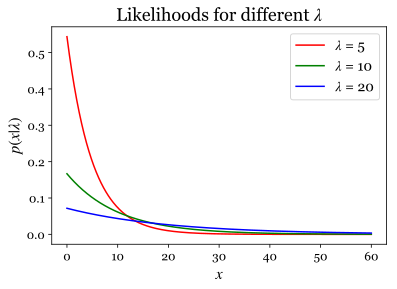

In [10]:
xs = np.linspace(0, 60, 500) # values of x at which to evaluate the likelihood
colors = ['red', 'green', 'blue'] # color of each line

for i, lamb in enumerate([5, 10, 20]): # at each step enumerate does: i, lamb = number_of_iteration, list_entry
    Z = lamb*(np.exp(-5/lamb) - np.exp(-50/lamb)) # different Z for each lambda
    lik = np.exp(-xs/lamb)/Z # evaluate the likelihood for all xs at once (Numpy is very handy)
    
    plt.plot(xs, lik, color = colors[i], label = '$\lambda$ = {}'.format(lamb)) # plot
    beautify_plot({"title":"Likelihoods for different $\lambda$", "x":"$x$", "y":'$p(x|\lambda)$'})

plt.gca().legend(fontsize = 14) # add legend for maximum style
plt.show()

For smaller $\lambda$ the curve concentrates most of its area close to the origin, whereas for larger $\lambda$ it is more spread out, which is expected from the expression for the exponential decay.

We've written down the likelihood of a single measurement, $x$ $-$ what is the likelihood $p(\{x\}|\lambda)$ of the whole dataset $\{x\}$? Assuming that the particles decay independently from each other it can be shown, using Bayes' rule, that

$$\begin{align}
p(\{x\}|\lambda) = \frac{1}{\lambda^N} \text{exp}\bigg(-\frac{\sum_{n = 0}^{N} x_n}{\lambda}\bigg)
\end{align}$$

<details>
<summary>Likelihood in more detail</summary>
<div>
Since the decays are all independent from each other, the conditional probabilities of each \(x_i\) simplify

$$
~\\
p(x_i|\{x\}_{i\neq j}) = p(x_i)\\
$$

Then, using Bayes’ rule

\begin{align}
p(x_1, x_2, … x_N) &= p(x_1 | x_2, x_3 … x_N) p(x_2, x_3 … x_N)\\
~\\
&= p(x_1)p(x_2, x_3 … x_N)\\
~\\
&=\cdots\\
~\\
&= \prod^N_{n = 1} p(x_n)~~~\text{by induction}\\
~\\
&= \frac{1}{Z(\lambda)^N} \text{exp}\bigg(\frac{\sum^N_{n = 1} x_n}{\lambda}\bigg)\\
\end{align}
</div>
</details>

The last piece is $p(\lambda)$. This is the probability distribution of $\lambda$ prior to any measurements and is therefore commonly referred to as the **prior distribution**. It encodes our belief about the $\lambda$ prior to observing any data. In this example we expect $\lambda > 0$ (for an exponential decay rather than growth), but other than this we do not expect a certain value of $\lambda$ to be more probable than others. For the moment, let us assume that $\lambda$ is uniformly distributed on the interval $[0, 100]$:

$$\begin{align}
p(\lambda) = \mathcal{U}(\lambda;0, 100).
\end{align}$$

This choice is somewhat arbitrary and we will return to the question of prior selection later. Let's summarize the picture:

- $p(\lambda | \{x\})$ is the **posterior distribution**, given by Bayes $$\begin{align}
p(\lambda|\{x\}) \propto p(\{x\}|\lambda)p(\lambda)\\ \end{align}$$


- $p(\{x\}|\lambda)$ is the **likelihood**, generally given by the underlying model responsible for generating the data. In our example:

$$\begin{align}
p(\{x\}|\lambda) = \frac{1}{Z(\lambda)^N} \text{exp}\bigg(-\frac{\sum_{n = 0}^{N} x_n}{\lambda}\bigg)
\end{align}$$

- $p(\lambda)$ is the **prior**, which represents our prior beliefs about the model parameter(s) prior to any measurements. In this example we assume:

$$\begin{align}
p(\lambda) \sim \mathcal{U}(0, 100)
\end{align}$$

Let's now plot the posterior distribution for our dataset.

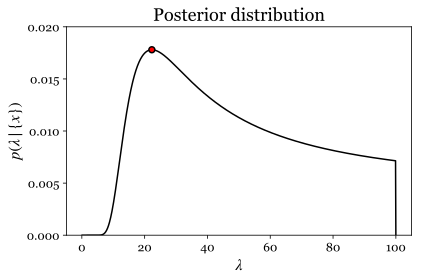

In [12]:
lambdas = np.linspace(0.1, 100, 1000) # Values of lambda where we want to evaluate the posterior.
Z = lambdas*(np.exp(-5/lambdas) - np.exp(-50/lambdas))

lik = np.exp(-np.sum(x)/lambdas)/Z**x.shape[0] # likelihood of the whole dataset

prior = np.heaviside(lambdas.max()-lambdas, 0)/(lambdas.max()-lambdas.min()) # uniform prior [0, 100]

post = lik*prior # calculate posterior (un-normalized)
dlamda = ((lambdas.max()-lambdas.min())/lambdas.shape[0]) # length of small line element dlamda
post /= post.sum()*dlamda # normalize posterior

plt.plot(lambdas, post, color = 'black', zorder = 1) # plot posterior
plt.scatter(lambdas[np.argmax(post)], post.max(), color='red', linewidth=1.5,
            edgecolor='black', zorder = 2) # mark the posterior maximum with red point
beautify_plot({"title":"Posterior distribution", "x":"$\lambda$", "y":'$p(\lambda \mid \{x\})$'})
plt.ylim([0, 0.02])
plt.yticks(np.linspace(0, 0.02, 5))
plt.tight_layout()
plt.savefig("radio_post.svg")
plt.show()

This posterior suggests that there is a range of likely values for $\lambda$ close to the peak of the posterior. How can we use the posterior to estimate the value of $\lambda$ $-$ with an uncertainty estimate? We could for example find the mean and variance of $\lambda$:

In [13]:
lamda_mean = (post*lambdas*dlamda).sum() # calculate the mean lamda by integration
lamda_std = (((lambdas - lamda_mean)**2)*post*dlamda).sum()**0.5 # calculate the lamda also by integration
print('lambda mean: {}, lambda standard deviation (uncertainty): {}'.format(lamda_mean.round(2), lamda_std.round(2)))

lambda mean: 48.65, lambda standard deviation (uncertainty): 24.79


We could instead make an estimate of $\lambda$ by using the maximum posterior value of $\lambda$ with the rms variation around that value as our error bars:

In [14]:
lamda_max = lambdas[np.argmax(post)] # use the maximum-posterior lamda as our estimate for lambda
lamda_std = (((lambdas - lamda_max)**2)*post*dlamda).sum()**0.5 # calculate the lamda also by integration
print('lambda mean: {}, lambda uncertainty: {}'.format(lamda_max.round(2), lamda_std.round(2)))

lambda mean: 22.3, lambda uncertainty: 36.18


This approach of estimating the parameter(s) of the model to have value(s) which maximize(s) the posterior the is called *maximum a posteriori* or MAP. In this example, the MAP estimate gives a smaller $\lambda$ than using the mean of $\lambda$ since more weight falls to the right than to the left of the maximum of the posterior distribution. We can also use the posterior to draw samples for $\lambda$ and see what the corresponding single-sample likelihoods $p(x^\star | \lambda, \{x\})$ look like:

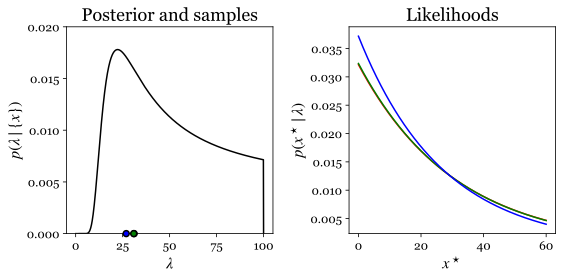

In [15]:
plt.figure(figsize = (8, 4))
for n in range(3):
    
    lambda_sample = np.random.choice(lambdas, p = post/post.sum()) # random choice from lambdas with probabilities p
    lik_sample = np.exp(-xs/lambda_sample)/lambda_sample # single-sample likelihood for sampled lambda
    
    plt.subplot(1, 2, 1)
    plt.scatter(lambda_sample, 0, marker = 'o', linewidth = 1.5,
                edgecolor = 'black', zorder = 3, color = colors[n], clip_on = False) # plot point
    
    plt.subplot(1, 2, 2)
    plt.plot(xs, lik_sample, color = colors[n]) # plot likelihood
    
plt.subplot(1, 2, 1)
plt.ylim([0, 0.06])
plt.plot(lambdas, post, color = 'black', zorder = 1)
beautify_plot({"title":"Posterior and samples", "x":"$\lambda$", "y":"$p(\lambda \mid \{x\})$"})
plt.ylim([0, 0.02])
plt.yticks(np.linspace(0, 0.02, 5))

plt.subplot(1, 2, 2)
beautify_plot({"title":"Likelihoods", "x":"$x^\star$", "y":"$p(x^\star \mid \lambda)$"})
plt.tight_layout()
plt.show()

There is one final piece to this analysis, which is the predictive distribution for $x$: after observing the dataset $\{x\}$, what can we say about the probability distribution od the distance travelled by a new particle, $x^\star$. To obtain $p(x^\star \lvert \{x\})$ we must consider the probability-weighted sum of $p(x^\star \lvert \lambda)$ over all possible values of $\lambda$, weighted by the probability \\( p(\lambda \lvert \{x\}) \\) of each \\( \lambda \\)

$$
p(x^\star \lvert \{x\}) = \int p(x^\star \lvert \lambda) p(\lambda \lvert \{x\}) d\lambda.
$$

The above integral combines our knowledge of how \\(x^\star\\) depends on the decay constant \\(\lambda\\), through the single-point likelihood \\(p(x^\star \lvert \lambda)\\), and how \\(\lambda\\) depends on the data \\(\{x\}\\), through the posterior \\(p(\lambda \lvert \{x\})\\).

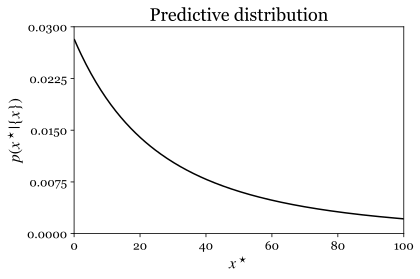

In [16]:
lambdas = np.linspace(0.1, 100, 1000)
xs = np.linspace(0.1, 100, 200)
l_grid, x_grid = np.meshgrid(lambdas, xs)
lik = 1/l_grid*np.exp(-x_grid/l_grid)

integrand = lik*post
dlambda = (lambdas.max() - lambdas.min())/lambdas.shape[0]
predictive = integrand.sum(axis = 1)*dlambda

plt.plot(xs, predictive, color = 'black')
beautify_plot({"title":"Predictive distribution", "x":"$x^\star$", "y":"$p(x^\star|\{x\})$"})
plt.xlim([0, 100])
plt.ylim([0, 0.03])
plt.yticks(np.linspace(0, 0.03, 5))
plt.tight_layout()
plt.show()

This decaying distribution shows that smaller values of \\(x^\star\\) are more likely. A question to point out at this stage is that although we haven't observed a value of \\(x^\star < 5\\), the predictive suggests that such a decay is in fact likely - even though in this system we will never actually observe this because of the detector window \\((5 < x^\star < 50)\\) introduced at the start. Why is the predictive assigning a high probabilty to \\(x^\star < 5\\)? The answer is that the predictive is simply a weighted sum of exponential decays, each of which is monotonically decreasing, giving rise to an overall monotonically decreasing function - we have not included the window in the likelihood \\( p(x^\star \mid \lambda)\\). Although in this system we will never actually observe \\(x^\star < 5\\), the fact that we chose an exponential decay to model the data allows us to extrapolate outside the detector window.

In [17]:
dx = (xs.max() - xs.min())/xs.shape[0]
x_mean = (predictive*xs*dx).sum()
x_std = (predictive*(xs - x_mean)**2).sum()**0.5

print("Mean x: {}, standard deviation (uncertainty): {}".format(x_mean.round(2), x_std.round(2)))

Mean x: 25.79, standard deviation (uncertainty): 33.96


It is worth taking a moment to consider what has been done thus far. We have

1. Written down the likelihood $p(\{x^\star\}|\lambda)$ of observing the dataset $\{x^\star\}$.
2. **Placed a uniform posterior $p(\lambda)$** over $\lambda$ $-$ this was an assumption.
3. Applied Bayes' rule to find the posterior $p(\lambda|\{x^\star\})$ which told us how likely each value of $\lambda$ is after updating our knowledge of $\lambda$ with the data.
4. Calculated the probability distribution $p(x^\star | \{x\})$ of observing a new decay at distance $x^\star$ given the data.

And so we have obtained the probability distribution over $x^*$ above. This approach has been much more principled than our histogram approach $-$ which involved an arbitrary choice of bins, arbitrarily using least squares and a hard estimate of $\lambda$ (no estimate of the uncertainty on $\lambda$). Such approaches which place a distribution over model parameters are called **bayesian** because of the use of Bayes' rule to calculate the posterior distribution. The general recipe for a bayesian treatment is:

1. Write down the likelihood $p(\mathcal{D}|\{\lambda\})$ of observing the data $\mathcal{D}$ given model parameters $\{\lambda\}$ $-$ often refered to as the *generative model*.
2. **Assume a prior $p(\{\lambda\})$** over the parameter(s) of the model.
3. Apply Bayes' rule to find the posterior $p(\lambda|\mathcal{D})$.
4. Calculate the probability distribution of observing a new sample $s^\star$, $p(s^\star| \mathcal{D})$.

In [18]:
from IPython.display import display, HTML

display(HTML("""
<style>
.jupyter-widgets-disconnected::before{
    visibility: hidden;
}
</style>
"""))